<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Déployez-un-modèle-dans-le-cloud" data-toc-modified-id="Déployez-un-modèle-dans-le-cloud-1">Déployez un modèle dans le cloud</a></span><ul class="toc-item"><li><span><a href="#Préambule" data-toc-modified-id="Préambule-1.1">Préambule</a></span><ul class="toc-item"><li><span><a href="#Problématique" data-toc-modified-id="Problématique-1.1.1">Problématique</a></span></li><li><span><a href="#Objectifs-dans-ce-projet" data-toc-modified-id="Objectifs-dans-ce-projet-1.1.2">Objectifs dans ce projet</a></span></li></ul></li></ul></li><li><span><a href="#0.-Imports-et-fonctions" data-toc-modified-id="0.-Imports-et-fonctions-2">0. Imports et fonctions</a></span></li><li><span><a href="#1.-Traitement-des-données" data-toc-modified-id="1.-Traitement-des-données-3">1. Traitement des données</a></span></li><li><span><a href="#2.-Chargement-des-données-enregistrées-et-validation-du-résultat" data-toc-modified-id="2.-Chargement-des-données-enregistrées-et-validation-du-résultat-4">2. Chargement des données enregistrées et validation du résultat</a></span></li><li><span><a href="#3.-Visualisation-TSNE" data-toc-modified-id="3.-Visualisation-TSNE-5">3. Visualisation TSNE</a></span></li><li><span><a href="#4.-Test-de-classification" data-toc-modified-id="4.-Test-de-classification-6">4. Test de classification</a></span></li><li><span><a href="#5.-Conclusion" data-toc-modified-id="5.-Conclusion-7">5. Conclusion</a></span></li></ul></div>

# Déployez un modèle dans le cloud

## Préambule

### Problématique

La très jeune start-up de l'AgriTech, nommée "**Fruits**!" cherche à proposer des solutions innovantes pour la récolte des fruits.

La volonté de l’entreprise est de préserver la biodiversité des fruits en permettant des traitements spécifiques pour chaque espèce de fruits en développant des robots cueilleurs intelligents.

La start-up souhaite dans un premier temps se faire connaître en mettant à disposition du grand public une application mobile qui permettrait aux utilisateurs de prendre en photo un fruit et d'obtenir des informations sur ce fruit.

Pour la start-up, cette application permettrait de sensibiliser le grand public à la biodiversité des fruits et de mettre en place une première version du moteur de classification des images de fruits.

De plus, le développement de l’application mobile permettra de construire une première version de l'architecture **Big Data** nécessaire.

### Objectifs dans ce projet

1. Développer une première chaîne de traitement des données qui comprendra le **preprocessing** et une étape de **réduction de dimension**.
2. Tenir compte du fait que <u>le volume de données va augmenter très rapidement</u> après la livraison de ce projet, ce qui implique de:
 - Déployer le traitement des données dans un environnement **Big Data**
 - Développer les scripts en **pyspark** pour effectuer du **calcul distribué**

NB: ce notebook est adapté du notebook https://s3.eu-west-1.amazonaws.com/course.oc-static.com/projects/Data_Scientist_P8/Mode_ope%CC%81ratoire.zip

# 0. Imports et fonctions

In [1]:
from PIL import Image
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import PCA, StandardScaler 
from pyspark.ml.feature import IndexToString, StringIndexer
from pyspark.ml.functions import array_to_vector
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, element_at, pandas_udf, PandasUDFType, split
from sklearn.manifold import TSNE
from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

import io
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1685029921266_0001,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
# get model weights
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
brodcast_weights = sc.broadcast(new_model.get_weights())

def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

14536120/14536120 [==============================] - 0s 0us/step

In [3]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt/yarn/usercache/livy/appcache/application_1685029921266_0001/container_1685029921266_0001_01_000001/pyspark.zip/pyspark/sql/pandas/functions.py:398: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.

# 1. Traitement des données

Les données utilisées sont 12884 images stockées dans un bucket S3 (Dossier Test). 
Les resultats du traitement seront enregistrés dans le dossier Result.

In [4]:
# path
PATH = "s3://oc-p8-elena"
PATH_Data = PATH + "/Test"
PATH_Result = PATH + "/Results"
print("PATH:        "+\
      PATH + "\nPATH_Data:   "+\
      PATH_Data + "\nPATH_Result: " + PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

PATH:        s3://oc-p8-elena
PATH_Data:   s3://oc-p8-elena/Test
PATH_Result: s3://oc-p8-elena/Results

In [5]:
# data loading
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
# first 5 images
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+---------------------------------------------------+----------+
|path                                               |label     |
+---------------------------------------------------+----------+
|s3://oc-p8-elena/Test/Test/Watermelon/r_106_100.jpg|Watermelon|
|s3://oc-p8-elena/Test/Test/Watermelon/r_109_100.jpg|Watermelon|
|s3://oc-p8-elena/Test/Test/Watermelon/r_108_100.jpg|Watermelon|
|s3://oc-p8-elena/Test/Test/Watermelon/r_107_100.jpg|Watermelon|
|s3://oc-p8-elena/Test/Test/Watermelon/r_95_100.jpg |Watermelon|
+---------------------------------------------------+----------+
only showing top 5 rows

None

In [8]:
# features extraction with the function
# featurize_udf and the model MobileNet
features_df = images.repartition(24).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
# dataframe schema
features_df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)

In [10]:
# dataframe size
print((features_df.count(), len(features_df.columns)))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(12884, 3)

`features_df` est un dataframe spark contenant les arrays de features dans la colonne `features`. Afin de pouvoir realiser une analyse en composante principales (PCA), il faut transformes les array en vecteurs; je vais sauvegarder ces vecteurs dans la colonne `features_vectors`. Avant la PCA il faudra aussi faire un scaling.

In [8]:
# transformation of features arrays into vectors
features_df = features_df.withColumn("features_vectors", array_to_vector('features'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
# pour demo soutenance
features_df.write.mode("overwrite").parquet(PATH + "/Soutenance")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
# pour demo soutenance
df = pd.read_parquet(PATH + "/Soutenance", engine='pyarrow')
df.head()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                                path  ...                                           features
0  s3://oc-p8-elena/Test/Test/Watermelon/r_67_100...  ...  [1.078297, 0.56316674, 0.0, 0.10359818, 0.6997...
1  s3://oc-p8-elena/Test/Test/Watermelon/r_97_100...  ...  [0.04990562, 0.1872394, 0.0, 0.005404015, 0.72...
2  s3://oc-p8-elena/Test/Test/Watermelon/r_180_10...  ...  [0.12589382, 0.01979928, 0.0, 0.0, 2.8102999, ...
3  s3://oc-p8-elena/Test/Test/Watermelon/284_100.jpg  ...  [0.28515837, 0.20028508, 0.0, 0.027041601, 1.9...
4  s3://oc-p8-elena/Test/Test/Watermelon/290_100.jpg  ...  [0.30722138, 0.016182655, 0.0, 0.0046964763, 2...

[5 rows x 3 columns]

In [10]:
# pour demo soutenance
df.loc[0,'features'].shape

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(1280,)

In [10]:
# checking features_vectors
features_df.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------+--------------------+--------------------+
|                path|         label|            features|    features_vectors|
+--------------------+--------------+--------------------+--------------------+
|s3://oc-p8-elena/...|    Watermelon|[1.078297, 0.5631...|[1.07829701900482...|
|s3://oc-p8-elena/...|    Watermelon|[0.04990562, 0.18...|[0.04990562051534...|
|s3://oc-p8-elena/...|Pineapple Mini|[0.0, 4.510494, 0...|[0.0,4.5104942321...|
|s3://oc-p8-elena/...|    Watermelon|[0.020706847, 0.2...|[0.02070684731006...|
|s3://oc-p8-elena/...|    Watermelon|[0.30722138, 0.01...|[0.30722138285636...|
|s3://oc-p8-elena/...|   Cauliflower|[0.0, 0.300869, 3...|[0.0,0.3008689880...|
|s3://oc-p8-elena/...|     Raspberry|[0.2114758, 0.398...|[0.21147580444812...|
|s3://oc-p8-elena/...|   Cauliflower|[0.0, 0.9022646, ...|[0.0,0.9022645950...|
|s3://oc-p8-elena/...|     Raspberry|[0.4011623, 0.250...|[0.40116229653358...|
|s3://oc-p8-elena/...|   Cauliflower|[0.

In [9]:
# scaling
scaler = StandardScaler(inputCol="features_vectors", outputCol="scaled_features")
scaler_model = scaler.fit(features_df)
features_df = scaler_model.transform(features_df)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
# PCA
pca = PCA(k=300, inputCol="scaled_features", outputCol="pca_features")
model_pca = pca.fit(features_df)
features_df = model_pca.transform(features_df)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
# explained variance
model_pca.explainedVariance.sum()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.9068958872953591

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

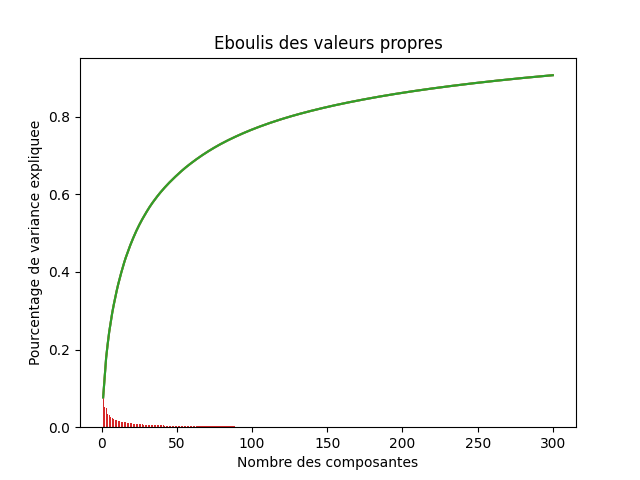

In [19]:
#Eboulis des valeurs propres
plt.bar(range(1,301), model_pca.explainedVariance)
plt.plot(range(1,301), model_pca.explainedVariance.cumsum())
plt.title('Eboulis des valeurs propres')
plt.xlabel('Nombre des composantes')
plt.ylabel('Pourcentage de variance expliquee')
%matplot plt

In [12]:
# saving in parquet format
features_df.write.mode("overwrite").parquet(PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# 2. Chargement des données enregistrées et validation du résultat

In [13]:
# loading data
df = pd.read_parquet(PATH_Result, engine='pyarrow')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
# first five rows
df.head()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                                path  ...                                       pca_features
0  s3://oc-p8-elena/Test/Test/Pineapple Mini/310_...  ...  {'type': 1, 'size': None, 'indices': None, 'va...
1  s3://oc-p8-elena/Test/Test/Watermelon/r_180_10...  ...  {'type': 1, 'size': None, 'indices': None, 'va...
2  s3://oc-p8-elena/Test/Test/Watermelon/284_100.jpg  ...  {'type': 1, 'size': None, 'indices': None, 'va...
3  s3://oc-p8-elena/Test/Test/Watermelon/266_100.jpg  ...  {'type': 1, 'size': None, 'indices': None, 'va...
4  s3://oc-p8-elena/Test/Test/Watermelon/263_100.jpg  ...  {'type': 1, 'size': None, 'indices': None, 'va...

[5 rows x 6 columns]

On valide que la dimension du vecteur des features est bien 300

In [31]:
# checking size of features vetor
df.loc[0,'pca_features']['values'].shape

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(300,)

In [14]:
# creation of features dataframe and saving to csv file
pca_features = pd.DataFrame(df["pca_features"].apply(lambda x: x['values']).tolist())
pca_features.to_csv(PATH + '/pca_features.csv')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# 3. Visualisation TSNE 

Dans cette partie, je vais realiser une TSNE sur les données afin de les visualiser en 2 dimensions et voir si on peut identifier des groupes d'images similaires, correspondants au meme fruit.

In [34]:
# TSNE
tsne = TSNE(2)
data_tsne = pd.DataFrame(tsne.fit_transform(pca_features), index = df.index)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/usr/local/lib64/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib64/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,

In [36]:
data_tsne["fruit"] = df["label"]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

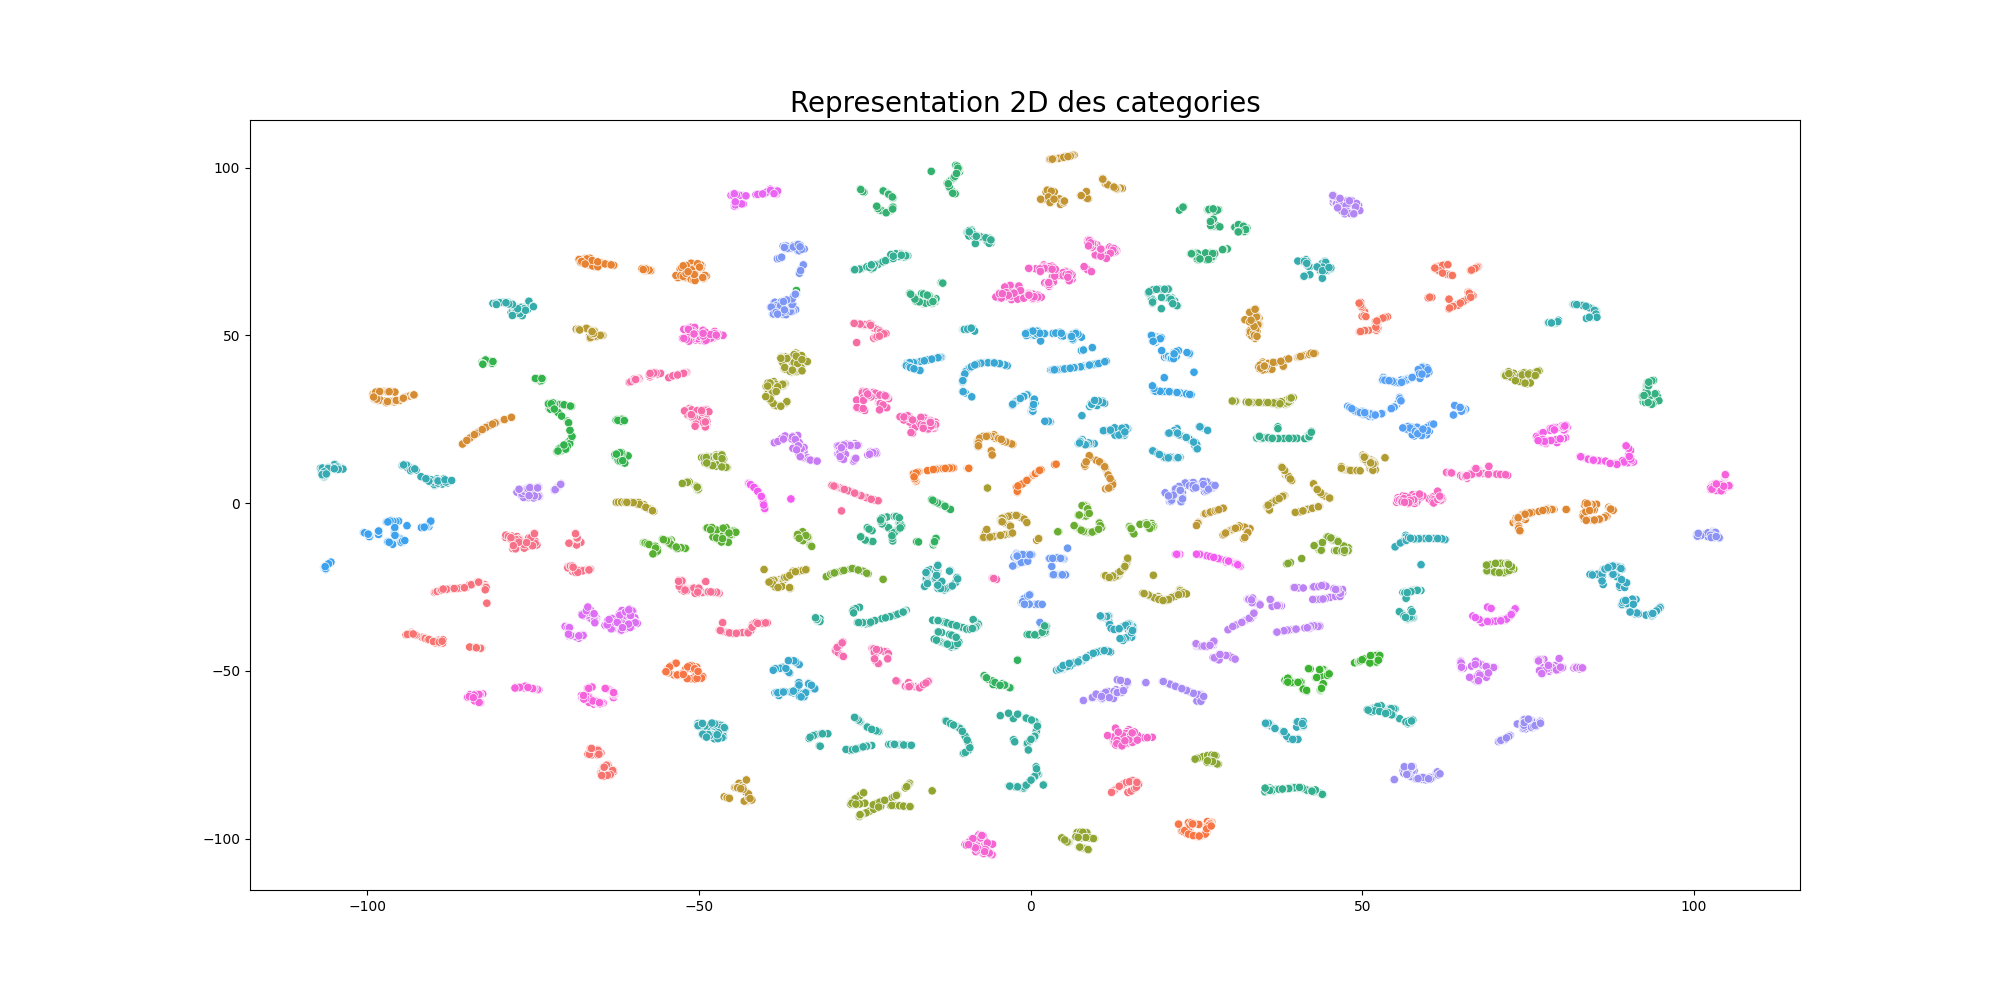

In [40]:
plt.figure(figsize=(20, 10))
sns.scatterplot(data=data_tsne, x=data_tsne[0], y=data_tsne[1], hue="fruit")
plt.title('Representation 2D des categories', fontsize=20)
plt.xlabel('')
plt.ylabel('')
plt.legend('', frameon=False)
%matplot plt

Plusieurs fruits ont des couleurs similaires, mais on peut bien identifier des groupes bien distincts, correspondants aux différents catégories de fruits.

# 4. Test de classification

Dans cette partie, je vais faire un test de classification avec un Random Forest

In [15]:
# categories labeling
labelIndexer = StringIndexer(inputCol='label',
outputCol='indexedLabel').fit(features_df)
rf_data = labelIndexer.transform(features_df).show(5, True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------+--------------------+--------------------+--------------------+--------------------+------------+
|                path|     label|            features|    features_vectors|     scaled_features|        pca_features|indexedLabel|
+--------------------+----------+--------------------+--------------------+--------------------+--------------------+------------+
|s3://oc-p8-elena/...|Watermelon|[0.2151034, 0.132...|[0.21510340273380...|[0.38528130419776...|[-24.396502847885...|        55.0|
|s3://oc-p8-elena/...|Watermelon|[0.12589382, 0.01...|[0.12589381635189...|[0.22549403281414...|[-11.520122867580...|        55.0|
|s3://oc-p8-elena/...|Watermelon|[0.28515837, 0.20...|[0.28515836596488...|[0.51075987522995...|[-18.833600387713...|        55.0|
|s3://oc-p8-elena/...|Watermelon|[0.00888299, 0.19...|[0.00888299010694...|[0.01591072000759...|[-18.412934201855...|        55.0|
|s3://oc-p8-elena/...|Watermelon|[0.10013937, 0.18...|[0.10013937205076...|[0.17936

In [16]:
# split in train and test set
(trainingData, testData) = features_df.randomSplit([0.8, 0.2])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
# instantiation random forest
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="pca_features", numTrees=200)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
# convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
labels=labelIndexer.labels)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
# pipeline instantiation and fit
pipeline = Pipeline(stages=[labelIndexer, rf,labelConverter])
model_rf = pipeline.fit(trainingData)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
# make predictions.
predictions = model_rf.transform(testData)
# select example rows to display.
predictions.select("features","label","predictedLabel").show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------+--------------+
|            features|       label|predictedLabel|
+--------------------+------------+--------------+
|[0.8719121, 0.117...|Avocado ripe|  Avocado ripe|
|[1.636343, 0.1955...|Avocado ripe|  Avocado ripe|
|[2.5134506, 0.008...|Avocado ripe|  Avocado ripe|
|[0.21587913, 0.0,...|     Avocado|       Avocado|
|[0.41267425, 0.02...|     Avocado|       Avocado|
+--------------------+------------+--------------+
only showing top 5 rows

In [21]:
# select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel",
    predictionCol="prediction",
    metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))
rfModel = model_rf.stages[-2]
print(rfModel) # summary only

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test Error = 0.0518777
RandomForestClassificationModel: uid=RandomForestClassifier_8dc83d154aac, numTrees=200, numClasses=73, numFeatures=300

In [22]:
#confusion matrix
cm_dt_result = predictions.crosstab("predictedLabel", "label")
cm_dt_result = cm_dt_result.toPandas()
cm_dt_result = cm_dt_result.sort_values(["predictedLabel_label"]).set_index('predictedLabel_label')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

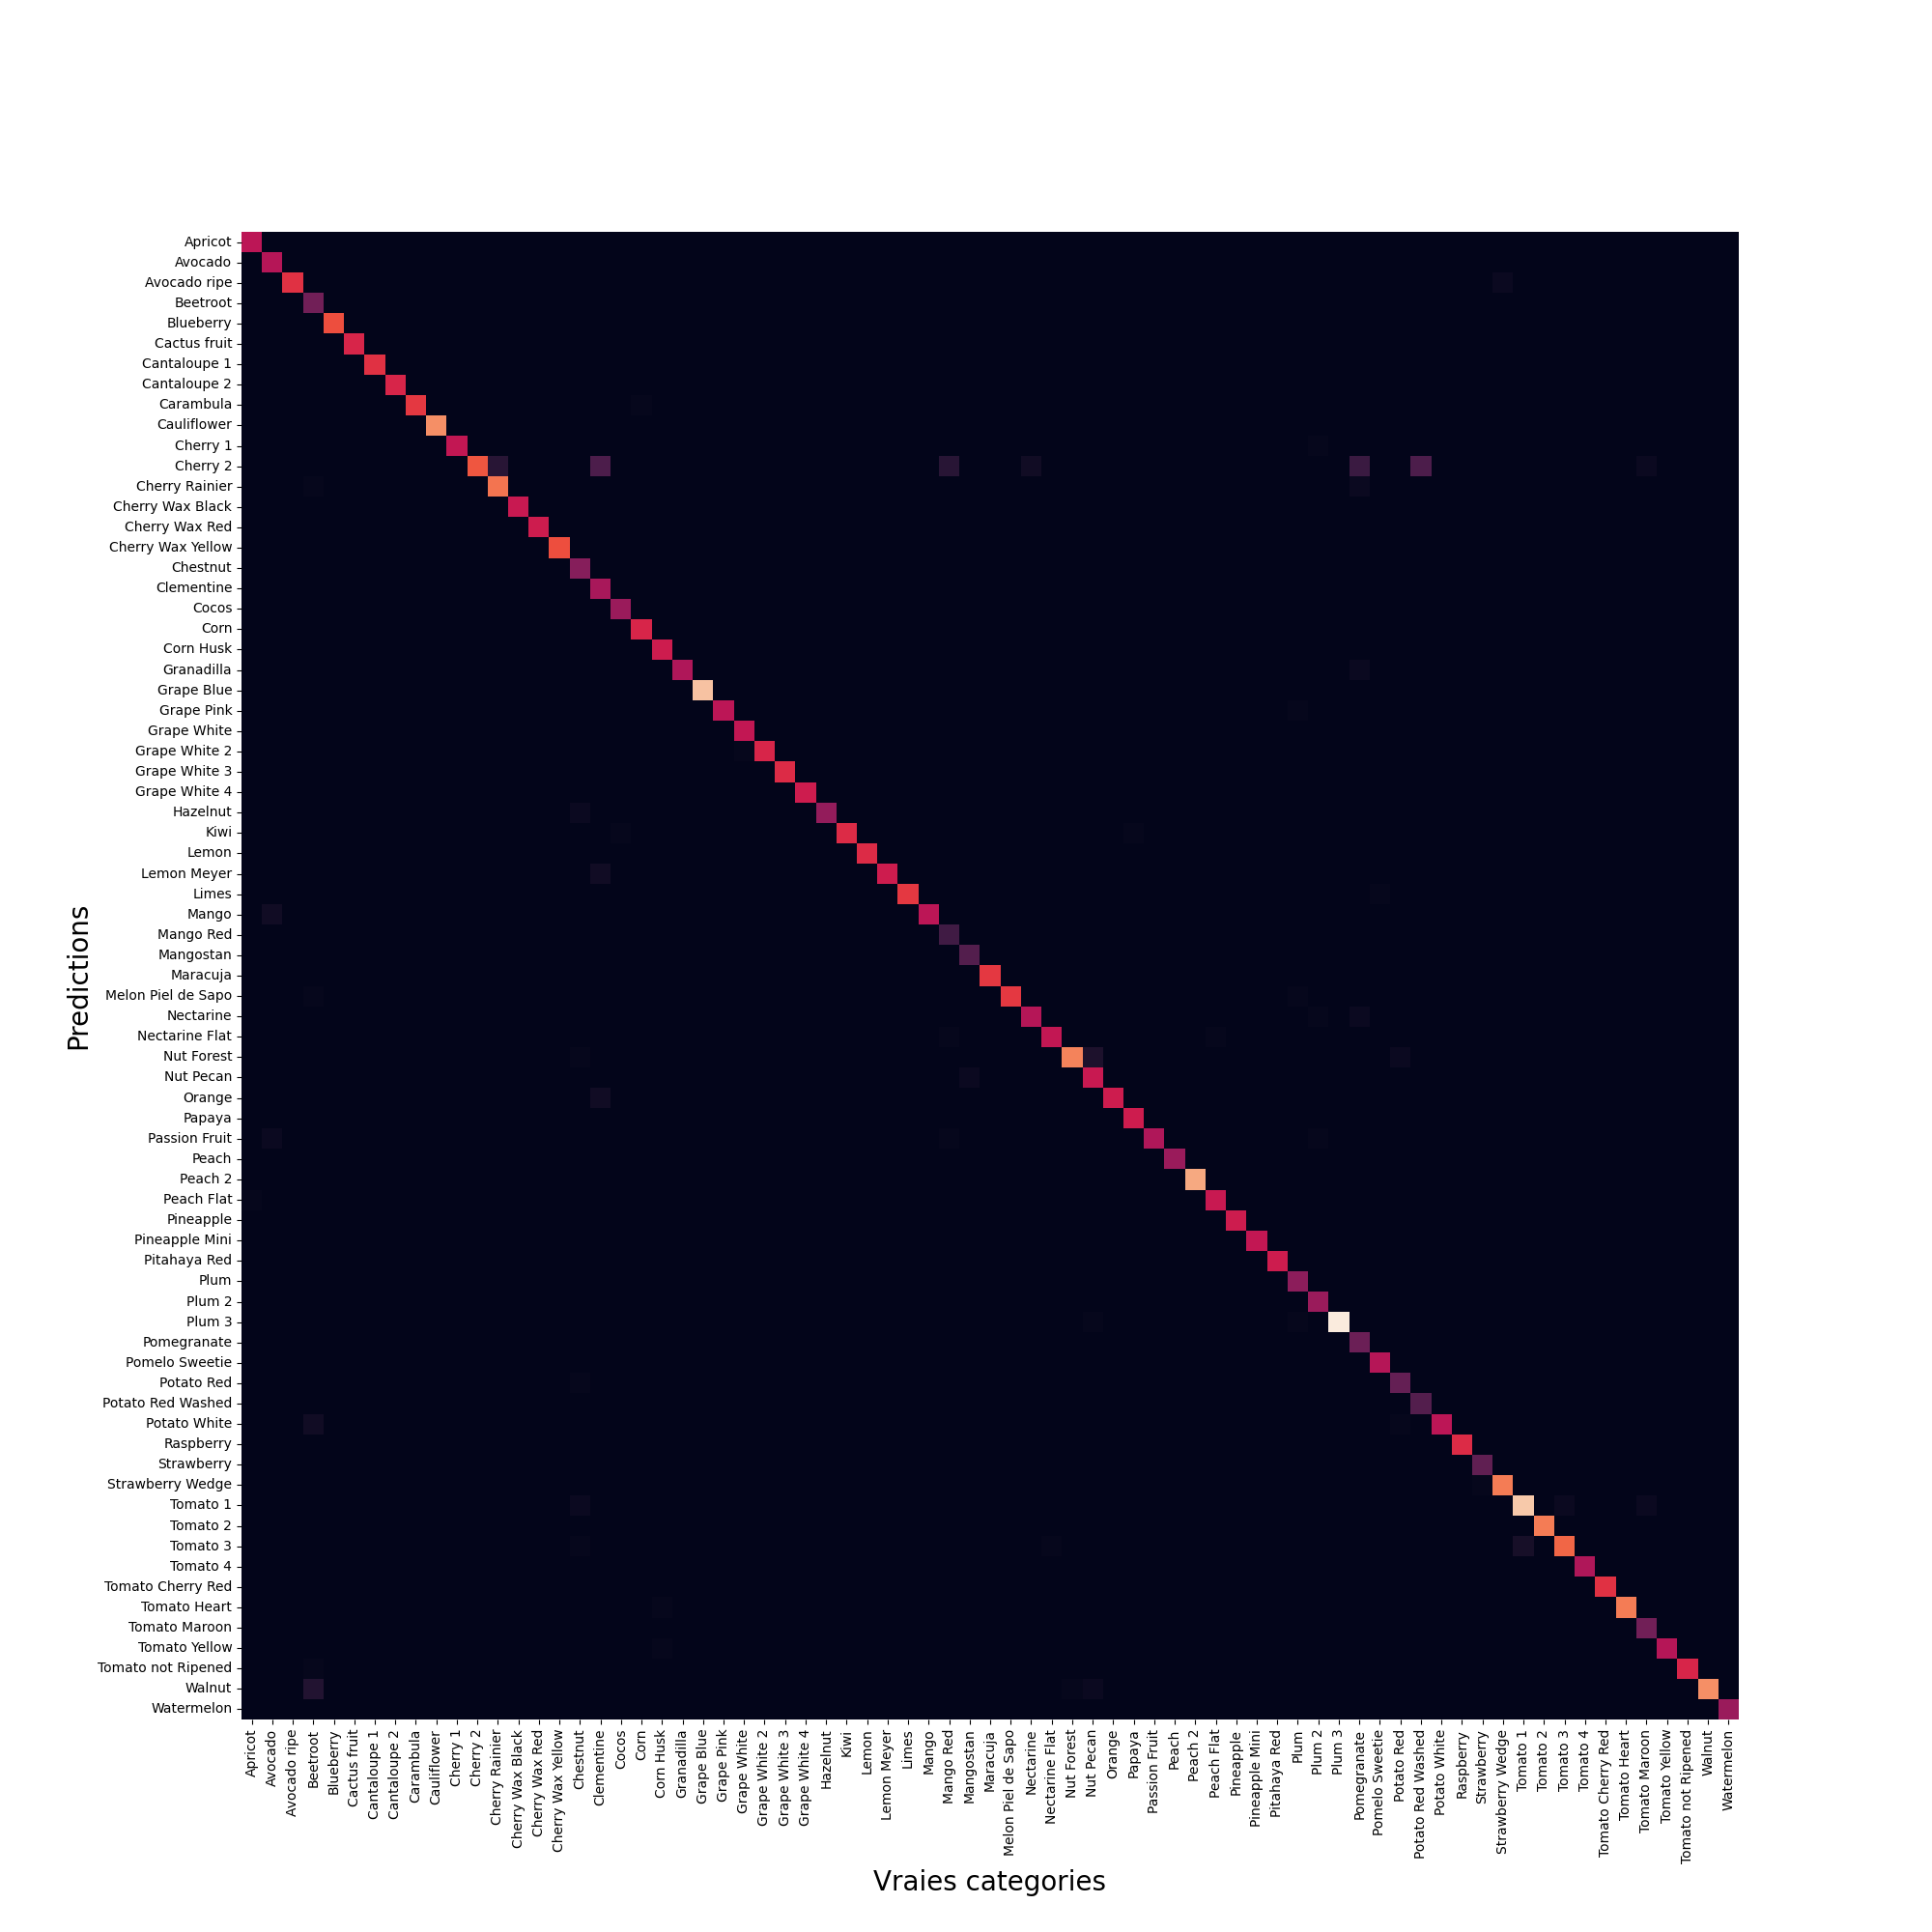

In [23]:
plt.figure(figsize=(20, 20))
sns.heatmap(cm_dt_result, cbar=False)
plt.xlabel("Vraies categories", fontsize=20)
plt.ylabel("Predictions", fontsize=20)
%matplot plt

Les résultats de la classification sont très satisfaisants : l'accuracy est proche de 100%. En regardant la matrice de confusion, on peut voir que le modèle confond deux types de noix et deux types de cerises, ce qui n'est pas étonnant.

# 5. Conclusion

Jai crée un **cluster de calcul** pour puvoir anticiper une future augmentation de la charge de travail.

Le meilleur choix retenu a été l'utilisation du prestataire de services **Amazon Web Services**, qui permet de **louer à la demande de la puissance de calculs** pour un coût tout à fait acceptable. Ce service se nomme **EC2** et se classe parmi les offres Infrastructure As A Service (IAAS).

J'ai utilisé un service de plus haut niveau (Plateforme As A Service PAAS), le service **EMR**, qui permet d'**instancier plusieurs serveur (un cluster)** sur lesquels j'ai pu demander l'installation et la configuration de plusieurs programmes et librairies nécessaires au projet.

En plus d'être plus **rapide et efficace à mettre en place**, on peut avoir la certitude du bon fonctionnement de la solution, celle-ci ayant été préalablement validé par les ingénieurs d'Amazon.

Enfin, j'ai pu **exécuter un notebook comme si j'ai l'avais fait localement** et traiter 12884 images. 
La chaine de traitement comprend:
 - le redimensionnement des images
 - une etape de  **transfert learning** à partir du model **MobileNetV2**, qui  été retenu pour sa légèreté et sa rapidité d'exécution ainsi que pour la faible dimension de son vecteur en sortie
 - une PCA sur les features extraites à l'aide de MobileNetV2

La classification realisée sur les features est presque parfaite.

Les résultats ont été enregistrés sur disque en plusieurs partitions au format **parquet**; un fichier csv contentant que les reultats de la PCA a egalement été enregistré.

les données sont stockées sur le service **Amazon S3** , qui, pour un faible coût, permet de stocker 
et exploiter de manière efficace les données.L'espace alloué est potentiellement illimité, mais les coûts seront fonction de l'espace utilisé.

Il sera **facile de faire face à une monté de la charge de travail** en **redimensionnant**  simplement le cluster de machines (horizontalement et/ou verticalement au besoin), les coûts augmenteront en conséquence mais resteront nettement inférieurs aux coûts engendrés par l'achat de matériels ou par la location de serveurs dédiés.